<a href="https://colab.research.google.com/github/Shravani2910/AI-Generated-Face-Detection/blob/main/AI_Generated_Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

BASE_DIR = "/content/drive/MyDrive/AI-face-detection-Dataset"
SPLIT_DIR = "/content/face_data"

for split in ["train", "val", "test"]:
    for cls in ["real", "AI"]:
        os.makedirs(os.path.join(SPLIT_DIR, split, cls), exist_ok=True)


In [4]:
import random
import shutil

def split_data(class_name, train_ratio=0.7, val_ratio=0.2):
    source_dir = os.path.join(BASE_DIR, class_name)
    images = os.listdir(source_dir)
    random.shuffle(images)

    total = len(images)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)

    splits = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, imgs in splits.items():
        for img in imgs:
            shutil.copy(
                os.path.join(source_dir, img),
                os.path.join(SPLIT_DIR, split, class_name, img)
            )

# Run for both classes
split_data("real")
split_data("AI")


In [5]:
for split in ["train", "val", "test"]:
    print(f"\n{split.upper()}")
    for cls in ["real", "AI"]:
        path = f"{SPLIT_DIR}/{split}/{cls}"
        print(f"{cls}: {len(os.listdir(path))}")



TRAIN
real: 1541
AI: 700

VAL
real: 440
AI: 200

TEST
real: 221
AI: 101


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
train_data = train_datagen.flow_from_directory(
    f'{SPLIT_DIR}/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

labels = train_data.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


Found 2241 images belonging to 2 classes.
{0: np.float64(1.6007142857142858), 1: np.float64(0.7271252433484751)}


In [7]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
IMG_SIZE = 224

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
# Data Generator

IMG_SIZE = 224
BATCH_SIZE = 32
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)
train_data = train_gen.flow_from_directory(
    SPLIT_DIR + "/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_data = val_test_gen.flow_from_directory(
    SPLIT_DIR + "/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_data = val_test_gen.flow_from_directory(
    SPLIT_DIR + "/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)
print(train_data.class_indices)

Found 2241 images belonging to 2 classes.
Found 640 images belonging to 2 classes.
Found 322 images belonging to 2 classes.
{'AI': 0, 'real': 1}


In [9]:
print(train_data.class_indices)

{'AI': 0, 'real': 1}


In [10]:
# building a Model

base_model = EfficientNetB0(
    weights = 'imagenet',
    include_top = False,
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)


In [12]:
from tensorflow.keras.optimizers import Adam

# Compiling the Model

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
# Training Model

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 81s 740ms/step - accuracy: 0.6720 - loss: 0.6415 - val_accuracy: 0.6875 - val_loss: 0.6261
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - accuracy: 0.6944 - loss: 0.6226 - val_accuracy: 0.6875 - val_loss: 0.6220
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 427ms/step - accuracy: 0.6994 - loss: 0.6127 - val_accuracy: 0.6875 - val_loss: 0.6207
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 30s 420ms/step - accuracy: 0.6816 - loss: 0.6278 - val_accuracy: 0.6875 - val_loss: 0.6205
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 30s 420ms/step - accuracy: 0.6911 - loss: 0.6204 - val_accuracy: 0.6875 - val_loss: 0.6213
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 30s 420ms/step - accuracy: 0.6922 - loss: 0.6218 - val_accuracy: 0.6875 - val_loss: 0.6203
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - accuracy: 0.6850 - loss: 0.6252 - val_accuracy: 0.6875 - val_loss: 0.6225
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.6907 - loss: 0.6223 - val_accu

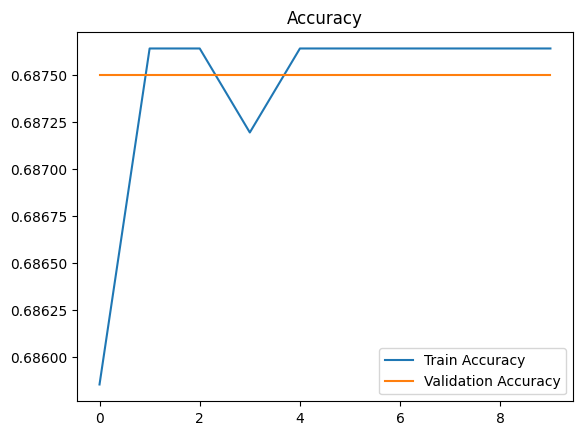

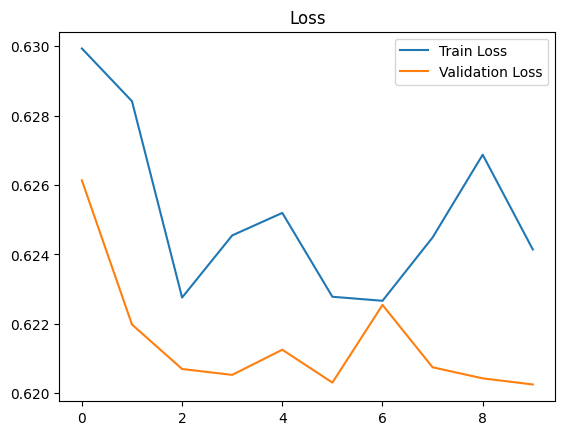

In [14]:
# Plotting

# Accuracy
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

# Loss
plt.show()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")
plt.show()


In [15]:
# Evaluating model

test_loss, test_acc = model.evaluate(test_data)
print("Test Accuracy:", test_acc)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4095 - loss: 0.8460
Test Accuracy: 0.6863353848457336


In [16]:
model.save("ai_face_detector.keras")


In [20]:
!ls


ai_face_detector.keras	drive  face_data  sample_data


In [21]:
!ls /content/drive/MyDrive


 AI-face-detection-Dataset
 ai_vs_real_face_detector.h5
 B400610341_DL.pdf
'Blood cell Cancer [ALL]'
 BrainTumor_Dataset
 cbt_based_chatbot.pdf
 Classroom
'Colab Notebooks'
 Dr.BraineeAI
'HumanAIze HACKTHON Idea (1).pdf'
'IMG-20240730-WA0047(1) (1).jpg'
'IMG-20240730-WA0047(1) (2).jpg'
'IMG-20240730-WA0047(1) (3).jpg'
'IMG-20240730-WA0047(1) (4).jpg'
'IMG-20240730-WA0047(1) (5).jpg'
'IMG-20240730-WA0047(1) (6).jpg'
'IMG-20240730-WA0047(1) (7).jpg'
'IMG-20240730-WA0047(1) (8).jpg'
'IMG-20240730-WA0047(1).jpg'
 IMG-20240730-WA0047.jpg
'IMG_20250826_103528 (1).jpg'
 IMG_20250826_103528.jpg
'ineuron OL.pdf'
 MRI_Dataset
'My Resume (2).pdf'
 pdf_docs
 RAG
'RenderCV_EngineeringResumes_Theme__1_ (1) (1).pdf'
'RenderCV_EngineeringResumes_Theme__1_ (1) (2).pdf'
'RenderCV_EngineeringResumes_Theme__1_ (1).pdf'
 Screenshot_2025-04-10-11-56-49-505_com.phonepe.app.jpg
 Shravani_jagtap_7666941356.pdf
'Shravani_Jagtap Resume (1).pdf'
'Shravani_Jagtap_Resume-2 (1).pdf'
'Shravani_Jagtap_Resume-2 (2).pdf

In [22]:
from tensorflow.keras.models import load_model

model = load_model("ai_face_detector.keras")


In [23]:
model.save("/content/drive/MyDrive/ai_face_detector.keras")


In [24]:
model = load_model("/content/drive/MyDrive/ai_face_detector.keras")
